<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_3%5D2019_2nd_ML_month_with_KaKR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_3]2019 2nd ML month with KaKR

## 1. import 및 데이터 준비

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
base_path = '/content/gdrive/MyDrive/인공지능/아이펠/ES/data'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
import missingno as msno
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_data_path = join(base_path+ '/train_Exp3.csv')
sub_data_path = join(base_path+ '/test_Exp3.csv')

## 2. 데이터 살펴보기

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [ ]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [ ]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

### 타겟값 분리 및 전처리를 위해 test와 train 데이터 합치기

In [ ]:
y = data['price']

del data['price']

In [ ]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [ ]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 3. 간단한 전처리 

### 1) 결측치 확인

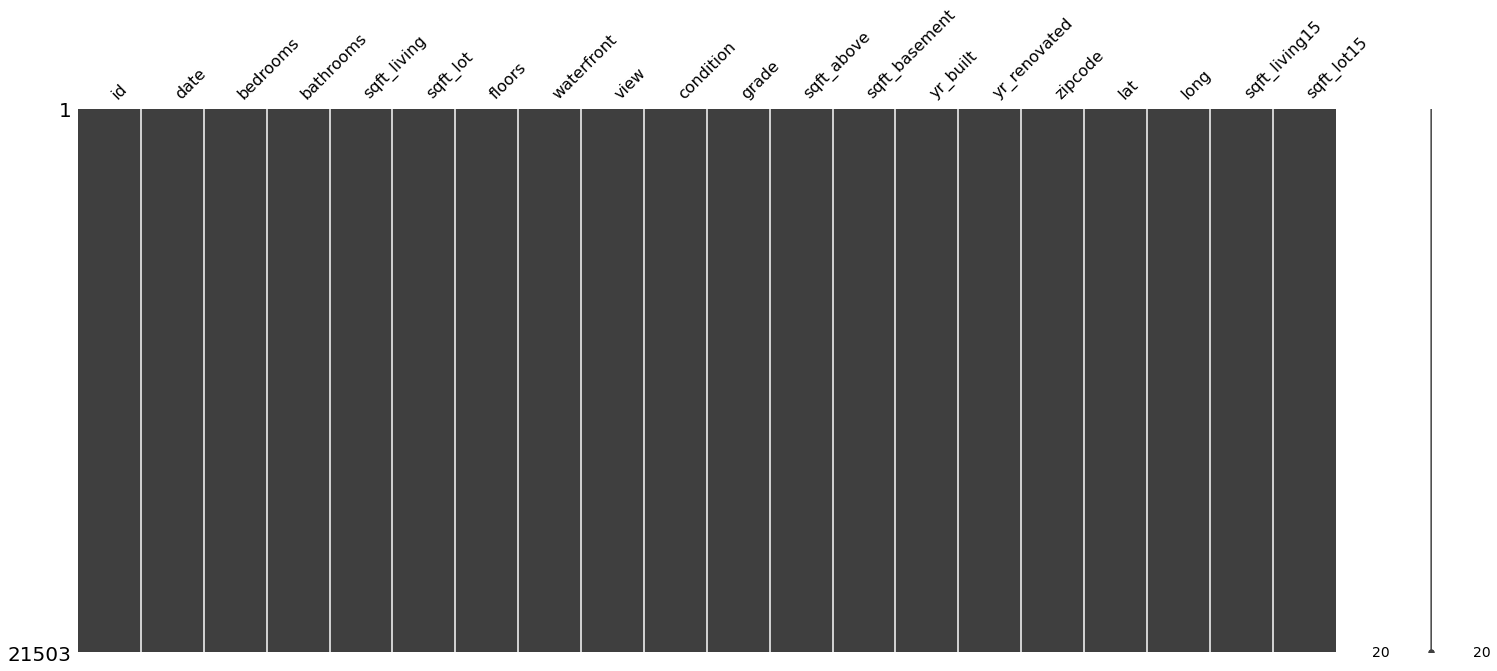

In [ ]:
msno.matrix(data)

In [ ]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


- 결측치는 없는 것으로 확인되었다.

### 2) id, date 변수 정리
  - id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
  - date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [ ]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

### 3) 각 변수들의 분포 확인
  - 한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있다.

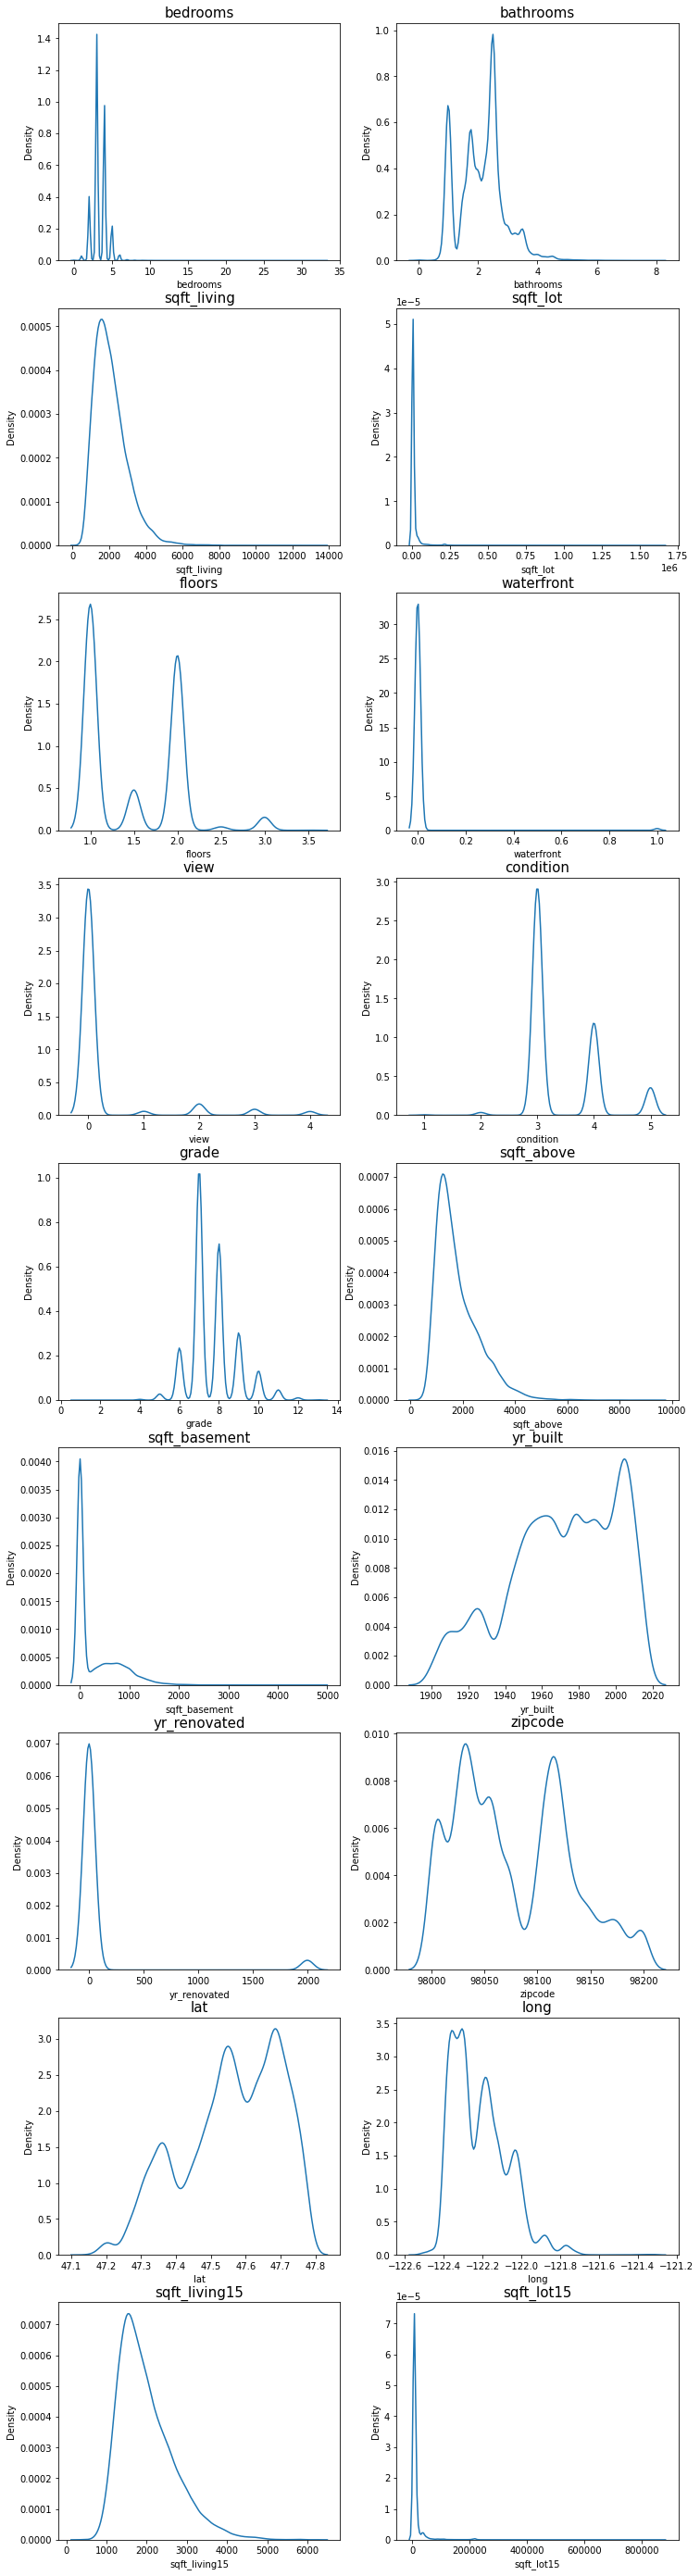

In [ ]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))    

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

- price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향이 있다.

In [ ]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

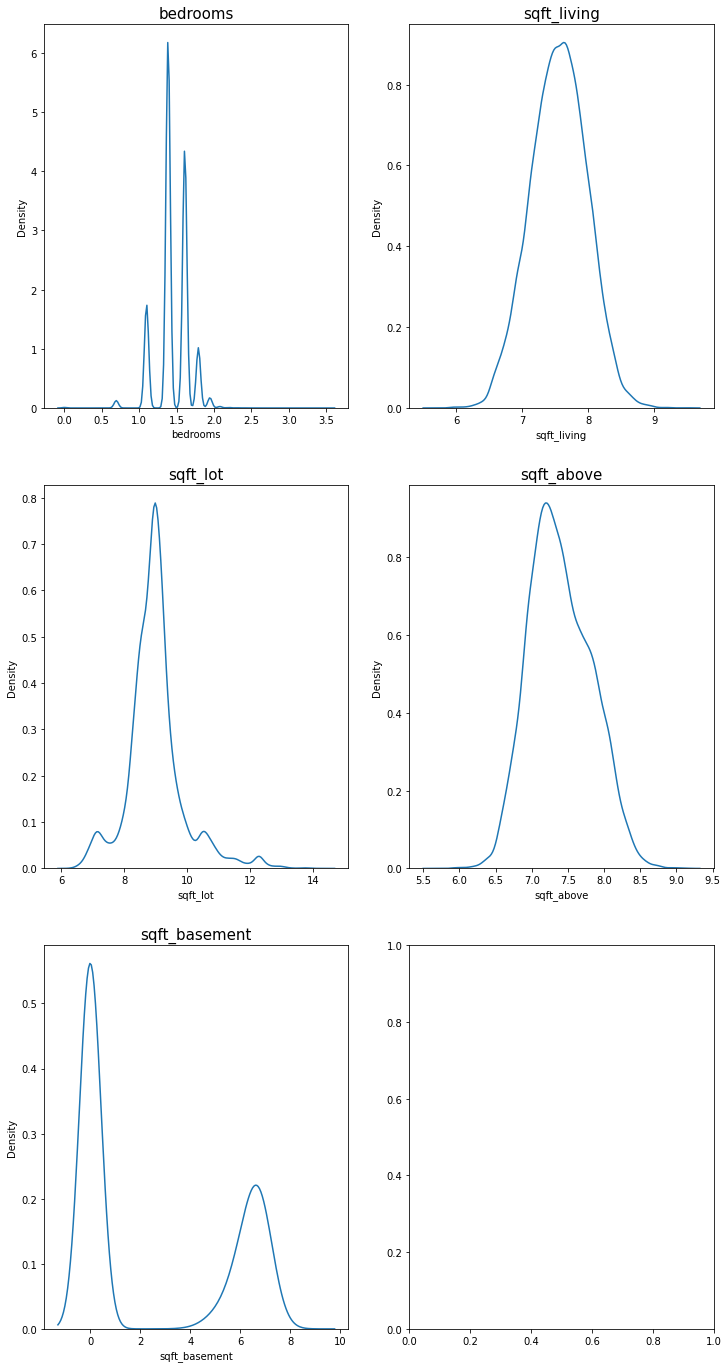

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 24))

count = 0
for row in range(3):
    for col in range(2):        
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
        if count == 5:
            break

## 4. 모델링전 test 데이터와 train 데이터로 분리한다.

In [ ]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 5. 모델링
### 1) gboost, xgboost, lightgbm, randomforestregressor 4가지 모델을 사용할 예정
  - randomforestregressor의 경우 시간대비 성능이 좋지 못해 최종 모델에서 선정에서는 제외되었다.

In [ ]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(objective='reg:squarederror',random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)
rfr = RandomForestRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model' : rfr, 'name' : 'rfr'}]

### 2) Cross Validation
  - 교차 검증을 통해 모델의 성능을 간단히 평가

In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")


In [ ]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8597
Model: XGBoost, CV score:0.8624
Model: LightGBM, CV score:0.8819
Model: rfr, CV score:0.8695


### 3) 그리드 탐색

In [ ]:
gboost_param_grid = {
    'n_estimators': [1700,1800 ],
    'max_depth': [3, 5 ],
    'learning_rate' : [0.01, 0.05]
}
  
xgbLight = {
    'feature_fraction': [0.5, 0.7],
    'bagging_fraction' : [0.5, 0.7],
    'n_estimators': [1700, 1800],
    'max_depth': [3, 5 ],
    'learning_rate' : [ 0.01, 0.05]

}

In [ ]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(x, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
my_GridSearch(gboost, x, y, gboost_param_grid,verbose=2, n_jobs=5  )

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
7,0.05,5,1800,-1.370379e+10,117063.171153
6,0.05,5,1700,-1.371521e+10,117111.973047
3,0.01,5,1800,-1.467950e+10,121158.983936
5,0.05,3,1800,-1.472328e+10,121339.537817
2,0.01,5,1700,-1.473294e+10,121379.314365
4,0.05,3,1700,-1.476720e+10,121520.355510
1,0.01,3,1800,-1.754651e+10,132463.257534
0,0.01,3,1700,-1.771372e+10,133092.901197


In [ ]:
my_GridSearch(xgboost, x, y, xgbLight,verbose=2, n_jobs=5  )

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,bagging_fraction,feature_fraction,learning_rate,max_depth,n_estimators,score,RMSLE
22,0.7,0.5,0.05,5,1700,-1.385698e+10,117715.685039
30,0.7,0.7,0.05,5,1700,-1.385698e+10,117715.685039
14,0.5,0.7,0.05,5,1700,-1.385698e+10,117715.685039
6,0.5,0.5,0.05,5,1700,-1.385698e+10,117715.685039
15,0.5,0.7,0.05,5,1800,-1.386611e+10,117754.453246
23,0.7,0.5,0.05,5,1800,-1.386611e+10,117754.453246
7,0.5,0.5,0.05,5,1800,-1.386611e+10,117754.453246
31,0.7,0.7,0.05,5,1800,-1.386611e+10,117754.453246
19,0.7,0.5,0.01,5,1800,-1.471075e+10,121287.899960
3,0.5,0.5,0.01,5,1800,-1.471075e+10,121287.899960


In [ ]:
my_GridSearch(lightgbm, x, y, xgbLight,verbose=2, n_jobs=5  )

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,bagging_fraction,feature_fraction,learning_rate,max_depth,n_estimators,score,RMSLE
23,0.7,0.5,0.05,5,1800,-1.409755e+10,118733.114632
7,0.5,0.5,0.05,5,1800,-1.409755e+10,118733.114632
22,0.7,0.5,0.05,5,1700,-1.411583e+10,118810.062340
6,0.5,0.5,0.05,5,1700,-1.411583e+10,118810.062340
30,0.7,0.7,0.05,5,1700,-1.462448e+10,120931.700912
14,0.5,0.7,0.05,5,1700,-1.462448e+10,120931.700912
15,0.5,0.7,0.05,5,1800,-1.463751e+10,120985.591764
31,0.7,0.7,0.05,5,1800,-1.463751e+10,120985.591764
21,0.7,0.5,0.05,3,1800,-1.492106e+10,122151.810191
5,0.5,0.5,0.05,3,1800,-1.492106e+10,122151.810191


### 4) 최적의 하이퍼파라미터 재모델링 및 성능 재평가

In [ ]:
gboost = GradientBoostingRegressor(learning_rate=0.05 ,max_depth=5,n_estimators=1800, random_state=2019)
xgboost = xgb.XGBRegressor(objective='reg:squarederror',learning_rate=0.05 ,max_depth=5,n_estimators=1700,feature_fraction=0.5,bagging_fraction =0.5,random_state=2019)
lightgbm = lgb.LGBMRegressor(learning_rate=0.05 ,max_depth=5,n_estimators=1800,feature_fraction=0.5,bagging_fraction =0.5,random_state=2019)
#rfr = RandomForestRegressor(max_depth=40,n_estimators=2000,random_state=2019)

In [ ]:
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [ ]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.9002
Model: XGBoost, CV score:0.8999
Model: LightGBM, CV score:0.8976


### 5) Make Submission
  - 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들어보겠다.

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    
    return np.mean(predictions, axis=1)

In [ ]:
y_pred = AveragingBlending(models, x, y, sub)

In [ ]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [ ]:
sub.to_csv('submission.csv', index=False)

## 6. 캐글 Submission 스코어 제출

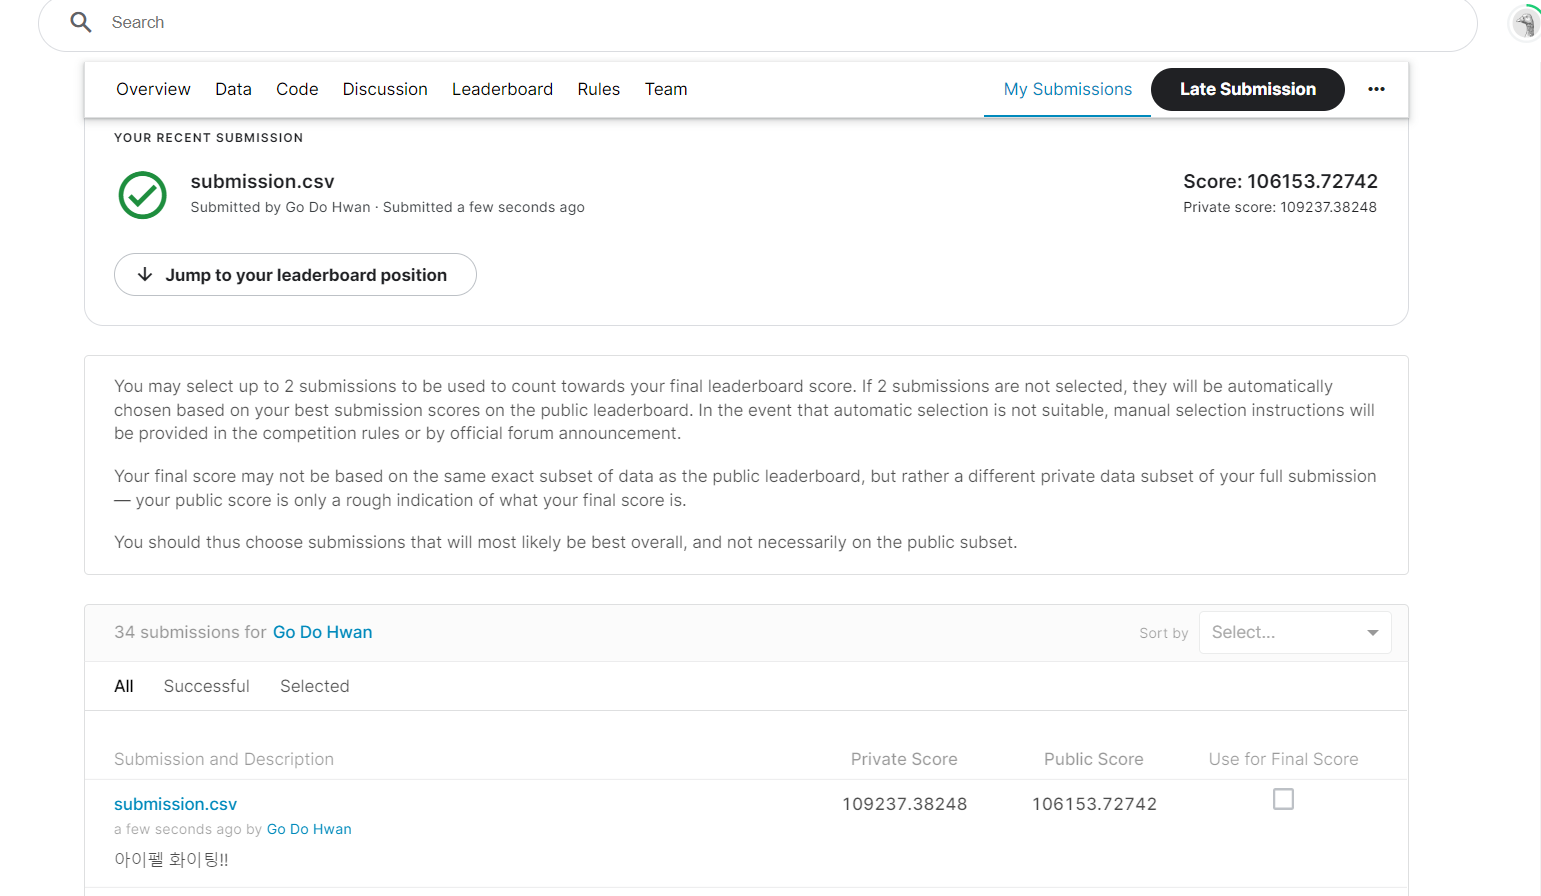

# 회고
  - 에러
    - XGBRegressor 모델에서 "WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror." 에러가 발생하여 다음 링크의 해결방법으로 해결하였다.
      - https://wooono.tistory.com/203

  - 루브릭조건에 맞추기 위해 시도했지만 실패한 것
    - y값 log 변환
      - y값을 log로 변환했지만 오히려 정확도와 점수가 6만점 까지 올라 성능이 떨어져 y에 log변환을 적용하지 않기로 했다.
    - RandomForestRegressor 사용
      - RandomForestRegressor를 사용하였지만 그리드서치와 모델학습에 시간이 너무 오래걸렸다. 그래서 최적의 하이퍼파라미터를 찾기가 어려웠다.
      - 시간대비 성능이 좋지 않았고 더이상 시간을 지체할 수 없어 과감히 이 모델을 포기하기로 하였다 그 뒤올 캐글 점수가 11만 이하로 내려갈 수 있었다.
    - 다양한 전처리
      - 캐글에 나와있는 여러 전처리를 적용하였지만 오히려 정확도와 점수가 좋지 않아졌다. 
      - 해당 링크에서 많이 참조했었다. -> https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12
      - 재건축 여부, 면적 대비 거실의 비율, 거실의 비율, 방의 전체 갯수등으로 전처리를 진행하였다.  
 
  - 공부해야할 것
    - 다음에는 그리드서치를 사용하기 전에 랜덤서치를 우선 사용하여 설정해야할 파라미터의 범위를 파악해야겠다. 
    - 그리드 서치를 하는데 너무 많은 수작업이 들어갔다.
  - Tip
    - 학습을 돌릴때 시간이 많이 걸리니 코랩창을 여러개 띄워서 학습을 하면 동시여 여러작업을 진행할 수 있다.
    - GPU사용을 위한 설정도 해볼 수 있다.
    - gboost, xgboost, lightgbm 3가지 모델이 최적이 파라미터 값이 비슷하게 나온다. 그중에서 lightgbm이 가장 빠르게 그리드서치와 학습이 진행되므로 우선 lightgbm부터 그리드서치와 모델 학습을 시켜 최적의 범위를 정한뒤 나머지 모델도 그리드서치와 학습을 진행하면 시간을 효율적으로 활용할 수 있을 것이다.